In [23]:
from PTFRNN import *
import os

# Testing Patching Functions

In [2]:
x = torch.arange(36).unsqueeze(0)

patch2d = Patch2D(3,6)

patch1d = Patch1D(9,36)

y2 = patch2d(x)

y1 = patch1d(x)

print(x.view(6,6))

print(y2)
print(patch2d.reverse(y2).view(6,6))
print(y1)
print(patch1d.reverse(y1).view(6,6))



tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])
tensor([[[ 0,  1,  2,  6,  7,  8, 12, 13, 14],
         [ 3,  4,  5,  9, 10, 11, 15, 16, 17],
         [18, 19, 20, 24, 25, 26, 30, 31, 32],
         [21, 22, 23, 27, 28, 29, 33, 34, 35]]])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])
tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
         [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
         [18, 19, 20, 21, 22, 23, 24, 25, 26],
         [27, 28, 29, 30, 31, 32, 33, 34, 35]]])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])


# PE2D sizing tests

In [3]:
def pe2Dtest(Lx,Ly):
    pe = torch.zeros(Lx*Ly, 2)
    for pos in range(Lx*Ly):
        x=pos//Ly
        y=pos%Ly
        # Only going to fill 3/4 of the matrix so the
        # occupation values are preserved
        #x direction encoding
        pe[pos, 0] =                 x
        #y direction encoding
        pe[pos, 1] =                 y
    return pe
pe2Dtest(3,2)

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.],
        [2., 0.],
        [2., 1.]])

# Testing PTFRNN

In [3]:
from PTFRNN import *
op=Opt(K=256,Q=1,Nh=128,dir="<NONE>",hamiltonian="TFIM",J=1,h=-1)
op.B=op.K*op.Q
op.patch=20
op.L= 100
op.sgrad=False
op.NLOOPS=op.L//op.patch

pb = PTFRNN(op.L,op.patch,_2D=op._2D,Nh=op.Nh,num_layers=2,rnnargs={"p":4})

pb1 = torch.jit.script(pb)

print(sum([p.numel() for p in pb.parameters()]))

1849104


In [2]:
altnet = PTF(op.patch,4,Nh=8,nhead=1,num_layers=2)
pb.prnn=altnet
print(sum([p.numel() for p in pb.parameters()]))

1884720


torch.Size([32, 256, 1])
Mean Difference: 1.7763568394002505e-14 (Var[P])^0.5: 4.417641765455302
--------------------
Mean Difference: 9.665879208142769e-15 (Var[P])^0.5: 4.383722721356397
tensor(-163.9395, device='cuda:0') tensor(-163.9395, device='cuda:0')
tensor(5.6843e-14, device='cuda:0')


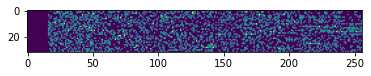

In [2]:
B=32

sample,p0 = pb.sample(B,op.L)
print(sample.shape)
ps = pb.logprobability(sample)

pvar,pmean = torch.var_mean(p0)

var,mean = torch.var_mean(abs(p0-ps))

print("Mean Difference:",mean.item(),"(Var[P])^0.5:",pvar.item()**0.5)

print("--------------------")



def get_indices(patch,L):
    sflip = torch.arange(L,device=device).to(torch.int64).reshape([1,L])
    sflip = patch(sflip).reshape(L)
    
    return sflip

probs = super(PTFRNN,pb).off_diag_labels(sample,nloops=op.NLOOPS)[:,get_indices(pb.patch,op.L)]
p2 = pb.off_diag_labels(sample,nloops=op.NLOOPS)

print("Mean Difference:",abs(probs-p2).mean().item(),"(Var[P])^0.5:",torch.var_mean(probs)[0].item()**0.5)
print(probs.mean(),p2.mean())
print(abs(probs-p2).max())
plt.imshow(abs(probs-p2).cpu())

In [ ]:
op.steps=100

beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
pb.parameters(), 
lr=op.lr,
betas=(beta1,beta2)
)

debug = reg_train(op,(pb,optimizer))
debug[-1,5]/op.L

Output folder path established
-0.38052 256
5,2.856|


In [8]:
import os
os.system("python RNN_QSR.py hamiltonian=TFIM L=40 NLOOPS=10 h=-1 J=1 patch=1")

0

In [9]:
os.system("python RNN_QSR.py hamiltonian=TFIM L=100 NLOOPS=25 h=-1 J=1 patch=1")
os.system("python RNN_QSR.py hamiltonian=TFIM L=100 NLOOPS=25 h=-1 J=1 patch=4")
os.system("python RNN_QSR.py hamiltonian=TFIM L=200 NLOOPS=50 h=-1 J=1 patch=4")
os.system("python RNN_QSR.py hamiltonian=TFIM L=500 NLOOPS=125 h=-1 J=1 patch=4")

0

In [21]:
os.system("python PTF.py hamiltonian=TFIM L=40 NLOOPS=10 h=-1 J=1 patch=4 K=512")
os.system("python PTF.py hamiltonian=TFIM L=100 NLOOPS=25 h=-1 J=1 patch=4 K=512")

0

In [22]:
os.system("python PTF.py hamiltonian=TFIM L=200 NLOOPS=50 h=-1 J=1 patch=4")

0

In [37]:
os.system("python PTF.py hamiltonian=TFIM L=500 NLOOPS=125 h=-1 J=1 patch=4 sgrad=False")

0

In [36]:
os.system("python PTF.py hamiltonian=TFIM L=120 NLOOPS=30 h=-1 J=1 patch=4 steps=100")

0

In [38]:
os.system("python PTF.py hamiltonian=TFIM L=100 NLOOPS=25 h=-1 J=1 patch=2 K=256 _2D=True")

0

In [20]:
op=Opt()
op.__dict__.clear()
op.apply(["x=1","y=False"])
print(op)

x                             			1
y                             			False



In [1]:
from PTFRNN import *
from PTFB import PTFB
#torch.set_default_tensor_type(torch.DoubleTensor)
op=Opt(K=256,Q=1,Nh=128,dir="PPTF",hamiltonian="Rydberg")
op.B=op.K*op.Q
op.patch=4
op.L= 256
op._2D=True
op.sgrad=False
op.NLOOPS=16

pb = PTFRNN(16,op.patch,_2D=op._2D,Nh=op.Nh,num_layers=2,rnnargs={"p":2,"_2D":True})

#Nh=[16,128,128]
altnet = PTFB(4,2,_2D=True,Nh=[32,128],nhead=4,num_layers=1)
pb.prnn=altnet

print(altnet.lin)

print(sum([p.numel() for p in pb.parameters()]))

pb1 = torch.jit.script(pb)


cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Ti', major=8, minor=6, total_memory=12287MB, multi_processor_count=80)
Sequential(
  (0): Linear(in_features=128, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): Softmax(dim=-1)
)
2079696


C:\Users\sprag\anaconda3\envs\pytorch\lib\site-packages\torch\jit\_recursive.py:229: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))


In [ ]:
beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
pb.parameters(), 
lr=op.lr,
betas=(beta1,beta2)
)

debug = reg_train(op,(pb,optimizer))

Output folder path established
-0.38052 256
1,3.012|
278,-0.325|555,-0.344|832,-0.351|1110,-0.357|1388,-0.370|1667,-0.377|1945,-0.379|2224,-0.380|
2503,-0.380|2783,-0.380|3062,-0.380|3341,-0.380|3620,-0.380|3899,-0.380|4178,-0.380|4457,-0.380|
4736,-0.380|5015,-0.381|5294,-0.381|5574,-0.380|5853,-0.380|6132,-0.380|6411,-0.381|

In [3]:
probs.shape

torch.Size([32, 256])

In [ ]:
os.system("git commit -a -m \"Auto Commit\"")
os.system("git push origin")

In [ ]:
import IPython
IPython.display.display(IPython.display.Javascript("IPython.notebook.save_notebook()"),include=['application/javascript'])

os.system("git commit -a -m \"Auto Commit\"")
os.system("git push origin")